In [1]:
import os
import math
from dotenv import load_dotenv

# Explicitly providing path to '.env'
from pathlib import Path  # Python 3.6+ only
# Load .env variables
_ = load_dotenv(dotenv_path=f"{Path().resolve().parents[1]}/src/.env")

# with the new api
from importnb import imports
with imports("ipynb"):
    from utils import df_from_csv, missing_data, correlation_data, plot_hist, plot_boxes, plot_lines, df_to_csv, drop_pm25_outliers

PM2.5: 35.9, AQI: 102
PM2.5: 35.9, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 35.5, Max: 55.4
AQI: 102, Measure Level: MeasureLevels.UNHEALTHY_FOR_SENSITIVE_GROUPS, Range Values: Min: 101, Max: 150


## PM2.5 Clean Data

In [2]:
# Load Raw Data
df_pm25_raw = df_from_csv("pm25_raw.csv")

# Check Data Types
print(df_pm25_raw.dtypes)

df_pm25_raw.head()

2023-12-15 15:36:34.863 | DEBUG    | utils:df_from_csv:340 - Load DataFrame: /home/sebaxtian/Workspaces/Tangara/tangara-evaluation/src/data/0_raw/pm25_raw.csv


TANGARA_3B7E    float64
TANGARA_3BEA    float64
TANGARA_421A    float64
TANGARA_422A    float64
TANGARA_5636    float64
TANGARA_D282    float64
dtype: object


,TANGARA_3B7E,TANGARA_3BEA,TANGARA_421A,TANGARA_422A,TANGARA_5636,TANGARA_D282
DATETIME,,,,,,
2023-11-26 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-26 00:00:30-05:00,7.0,7.0,7.0,NaN,NaN,NaN
2023-11-26 00:01:00-05:00,7.0,8.0,7.0,NaN,NaN,NaN
2023-11-26 00:01:30-05:00,7.0,6.0,6.0,7.0,7.0,6.0
2023-11-26 00:02:00-05:00,7.0,7.0,6.0,7.0,6.0,7.0


## Descriptive Statistics

In [3]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_3B7E,TANGARA_3BEA,TANGARA_421A,TANGARA_422A,TANGARA_5636,TANGARA_D282
count,39888.000000,39358.000000,39186.000000,38837.000000,38993.000000,39058.000000
mean,12.490649,11.825194,11.095085,11.209671,11.816429,12.580572
std,8.988992,8.587167,8.514329,8.584574,9.341073,9.560026
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7.000000,7.000000,6.000000,7.000000,7.000000,7.000000
50%,12.000000,11.000000,10.000000,10.000000,11.000000,12.000000
75%,16.000000,16.000000,15.000000,15.000000,15.000000,17.000000
max,834.000000,760.000000,647.000000,964.000000,546.000000,768.000000


## Missing Data

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Missing Data Threshold
threshold_data = float(os.getenv("THRESHOLD_MISSING_DATA", None))
print(f'Threshold Missing Data: {int(threshold_data * 100)}%')

# For each Tangara sensor
for id_tangara_sensor in df_pm25_raw.columns:
    df_pm25_sensor = df_pm25_raw[[id_tangara_sensor]]
    # To be checked
    to_be_checked, data_percent, missing_data_percent = missing_data(df_pm25_sensor, threshold_data)
    if to_be_checked:
        print(f"Tangara Sensor: {id_tangara_sensor}, To be checked: {to_be_checked}, Data: {data_percent}%, Missing Data: {missing_data_percent}%, Threshold: {threshold_data}%")

        # Drop Tangara Sensor from original dataframe
        df_pm25_raw = df_pm25_raw.drop(id_tangara_sensor, axis=1)

2023-12-15 15:36:34.999 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_3B7E, To be checked: False, Data: 92%, Missing Data: 8%, Threshold: 80%
2023-12-15 15:36:35.005 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_3BEA, To be checked: False, Data: 91%, Missing Data: 9%, Threshold: 80%
2023-12-15 15:36:35.010 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_421A, To be checked: False, Data: 91%, Missing Data: 9%, Threshold: 80%
2023-12-15 15:36:35.019 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_422A, To be checked: False, Data: 90%, Missing Data: 10%, Threshold: 80%
2023-12-15 15:36:35.027 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_5636, To be checked: False, Data: 90%, Missing Data: 10%, Threshold: 80%
2023-12-15 15:36:35.035 | DEBUG    | utils:missing_data:230 - Tangara Sensor: TANGARA_D282, To be checked: False, Data: 90%, Missing Data: 10%, Threshold: 80%


Threshold Missing Data: 80%


## Data Correlation

In [5]:
# Data Correlation Threshold
threshold_correlation = float(os.getenv("THRESHOLD_CORRELATION_DATA", None))
print(f'Threshold Correlation Data: {int(threshold_correlation * 100)}%')

# Tangara Sensor Reference
ID_TANGARA_REFERENCE=os.getenv("ID_TANGARA_REFERENCE", None)

# Tangara Sensors Target
IDS_TANGARA_TARGETS=os.getenv("IDS_TANGARA_TARGETS", None)
IDS_TANGARA_TARGETS = IDS_TANGARA_TARGETS.split(',') if IDS_TANGARA_TARGETS else ID_TANGARA_REFERENCE

# print(f"Tangara Sensor Reference: {ID_TANGARA_REFERENCE}, Tangara Sensors Target: {IDS_TANGARA_TARGETS}")

# Reference Tangara Sensor
df_tangara_reference = df_pm25_raw[[ID_TANGARA_REFERENCE]]

# For each Tangara Sensor Target
for id_tangara in IDS_TANGARA_TARGETS:
    if id_tangara in df_pm25_raw.columns:
        # Target Tangara Sensor
        df_tangara_target = df_pm25_raw[[id_tangara]]

        # To be checked
        if not math.isnan(df_tangara_reference.std()):
            has_corr, corr = correlation_data(df_tangara_reference, df_tangara_target, threshold_correlation)
            if not has_corr:
                print(f"Tangara Sensor Reference: {ID_TANGARA_REFERENCE}, Tangara Sensors Target: {id_tangara}, There is correlation: {has_corr}, Correlation: {float("{:.2f}".format(corr))}, Threshold: {threshold_correlation}")

                # Drop Tangara Sensor from original dataframe
                df_pm25_raw = df_pm25_raw.drop(id_tangara, axis=1)

Threshold Correlation Data: 70%


2023-12-15 15:36:35.081 | DEBUG    | utils:correlation_data:287 - Tangara Sensor Reference: TANGARA_5636, Tangara Sensors Target: TANGARA_3B7E, There is correlation: True, Correlation: 0.82, Threshold: 0.7
2023-12-15 15:36:35.100 | DEBUG    | utils:correlation_data:287 - Tangara Sensor Reference: TANGARA_5636, Tangara Sensors Target: TANGARA_3BEA, There is correlation: True, Correlation: 0.77, Threshold: 0.7
2023-12-15 15:36:35.120 | DEBUG    | utils:correlation_data:287 - Tangara Sensor Reference: TANGARA_5636, Tangara Sensors Target: TANGARA_421A, There is correlation: True, Correlation: 0.77, Threshold: 0.7
2023-12-15 15:36:35.139 | DEBUG    | utils:correlation_data:287 - Tangara Sensor Reference: TANGARA_5636, Tangara Sensors Target: TANGARA_422A, There is correlation: True, Correlation: 0.78, Threshold: 0.7
2023-12-15 15:36:35.154 | DEBUG    | utils:correlation_data:287 - Tangara Sensor Reference: TANGARA_5636, Tangara Sensors Target: TANGARA_5636, There is correlation: True, Corr

## Histograms

2023-12-15 15:36:51.663 | DEBUG    | utils:plot_hist:512 - Plot Histograms: True


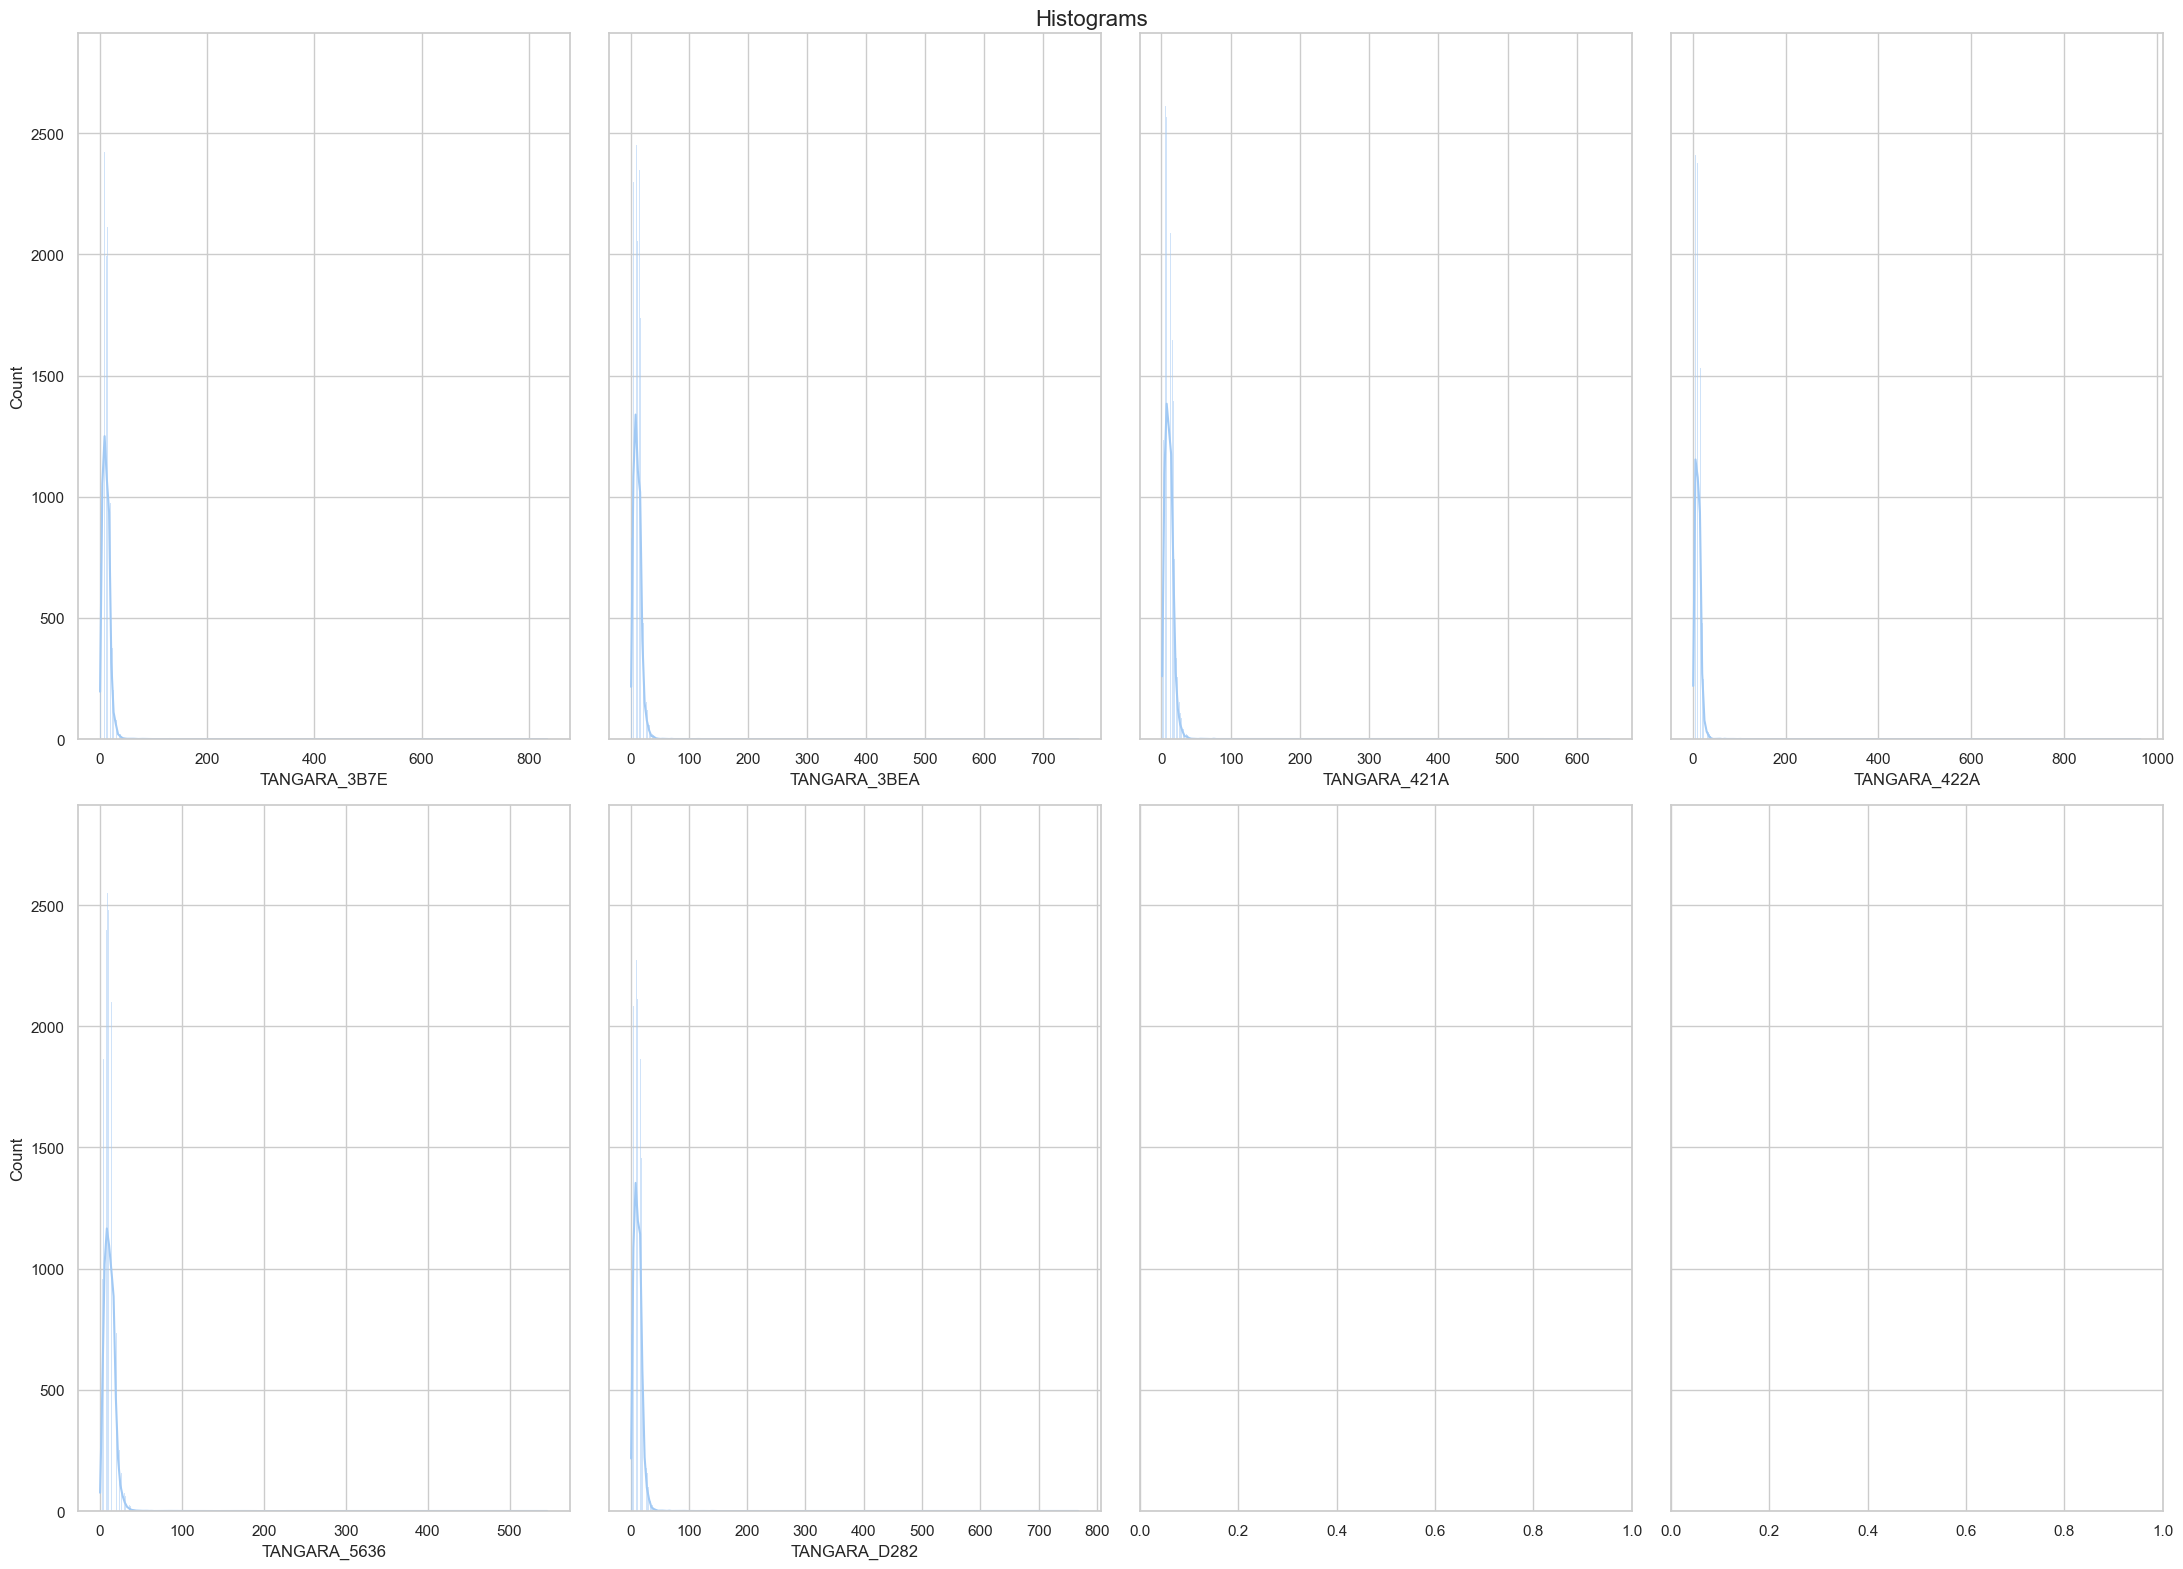

In [6]:
# Plot Histograms
plot_hist(df_pm25_raw)

## Boxplots

2023-12-15 15:37:06.592 | DEBUG    | utils:plot_boxes:545 - Plot Boxplots: True


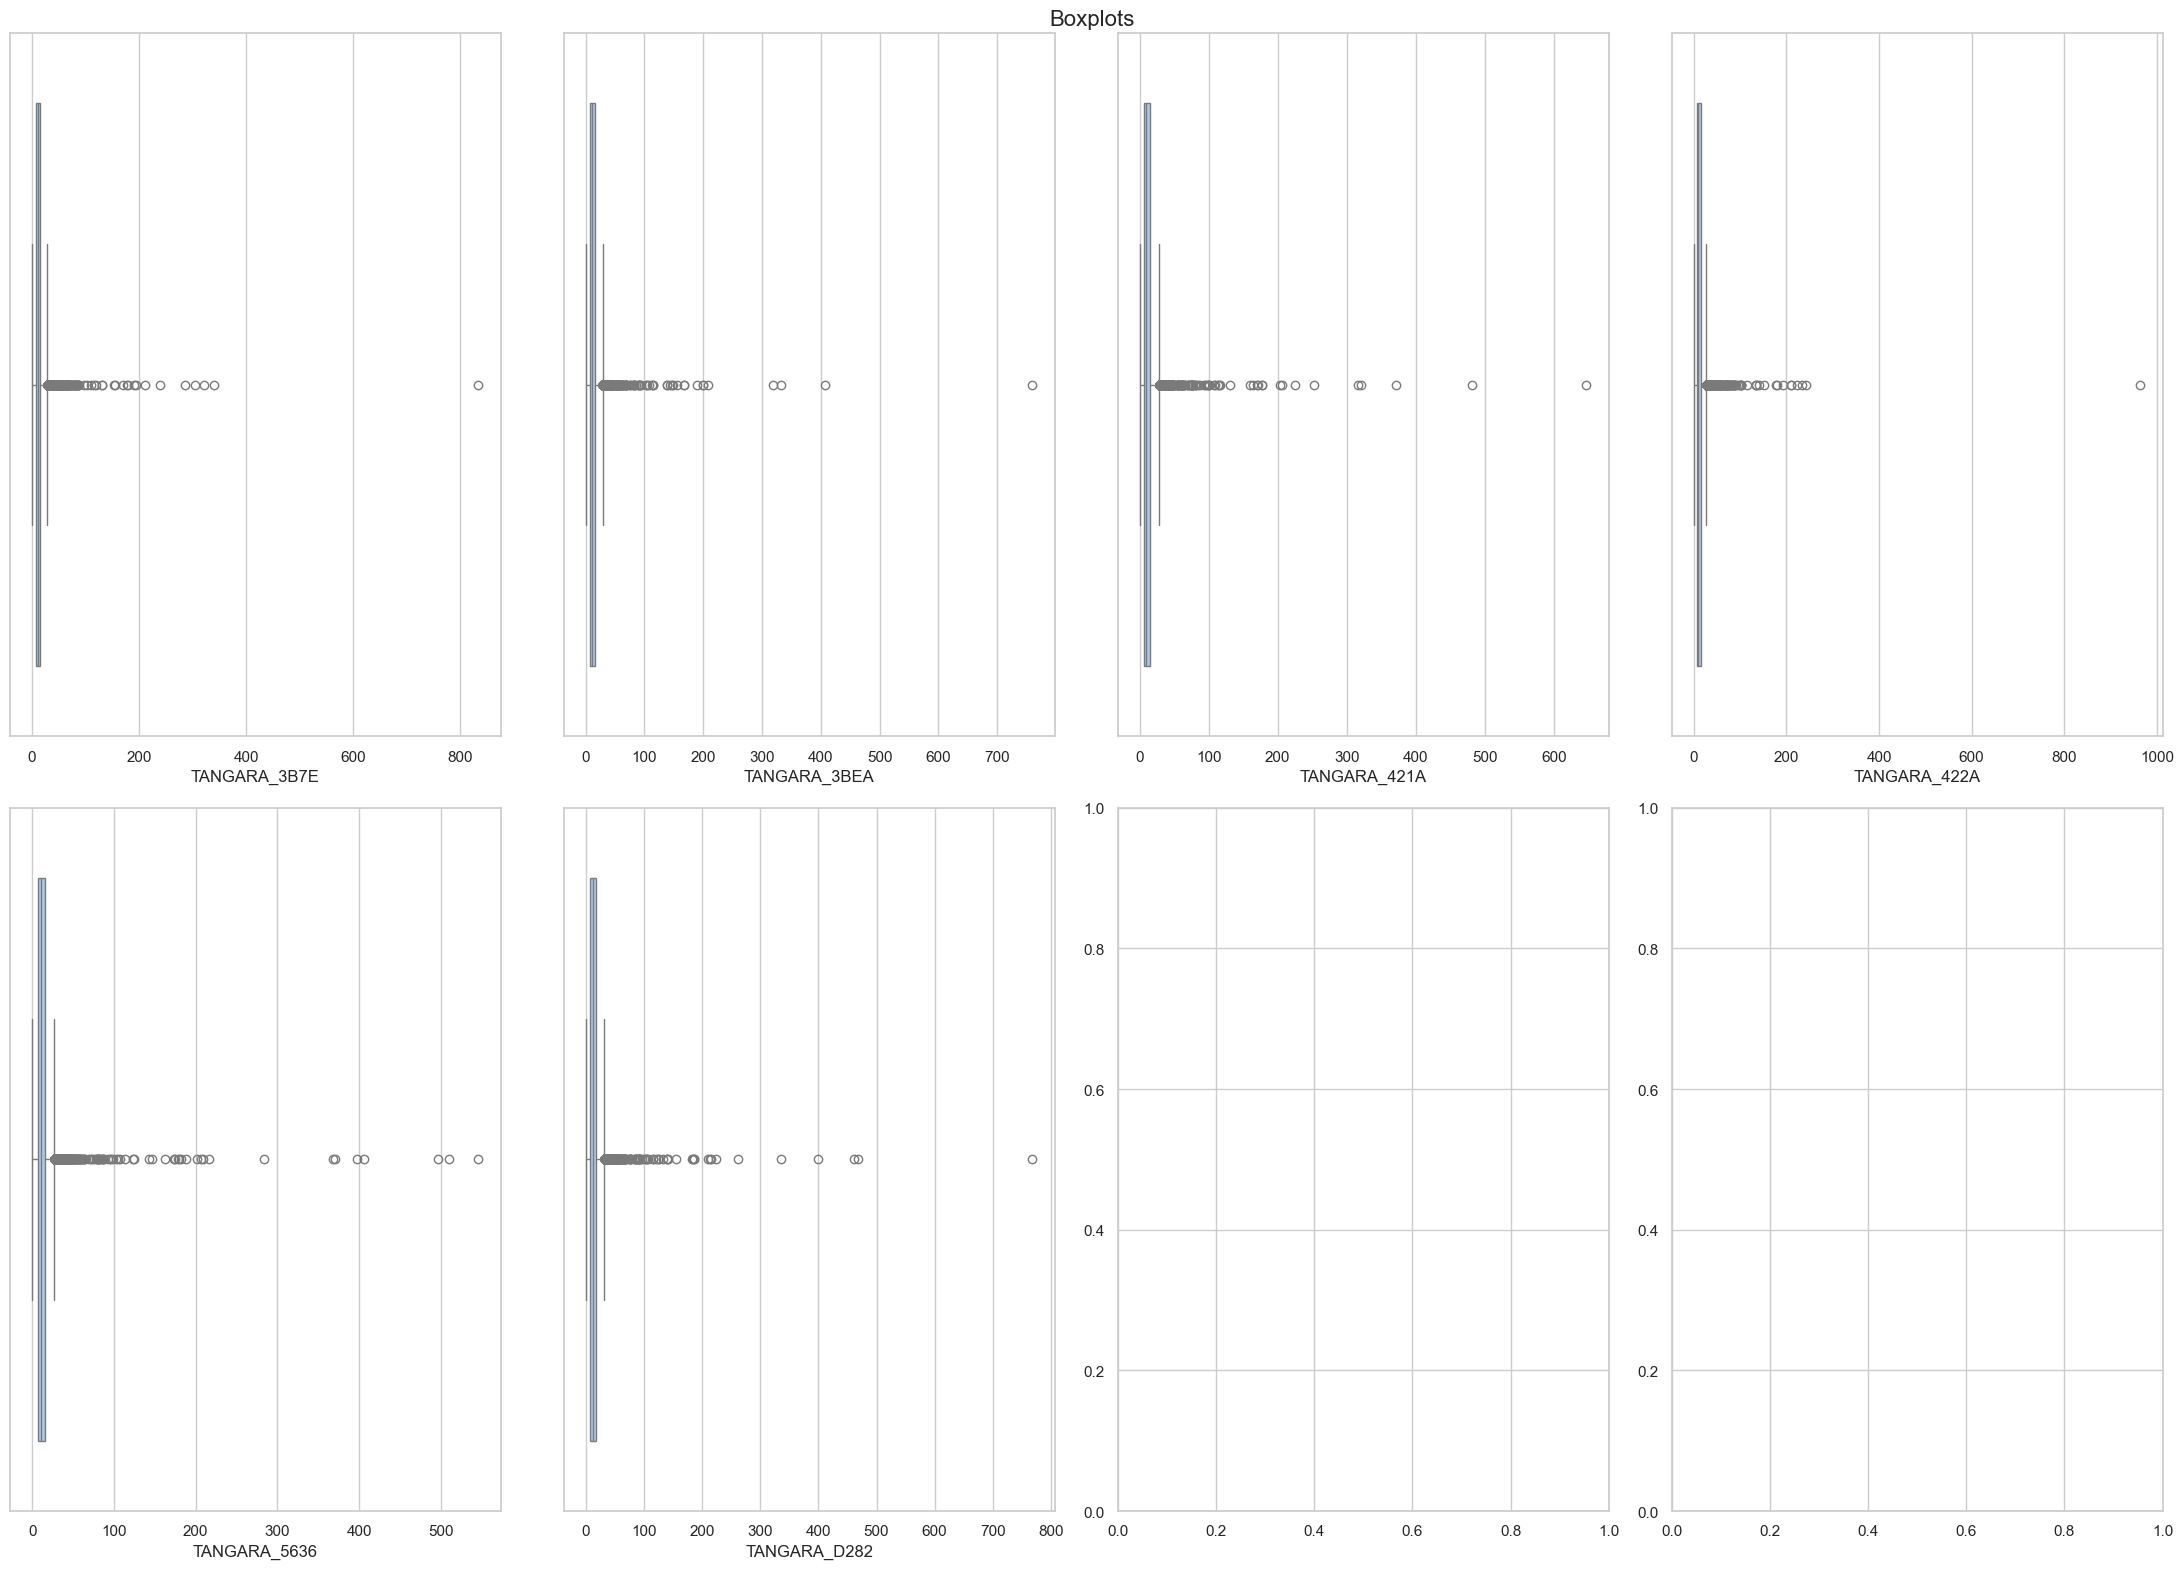

In [7]:
# Plot Boxplots
plot_boxes(df_pm25_raw)

## Lineplots

2023-12-15 15:37:22.146 | DEBUG    | utils:plot_lines:586 - Plot Lineplots: True


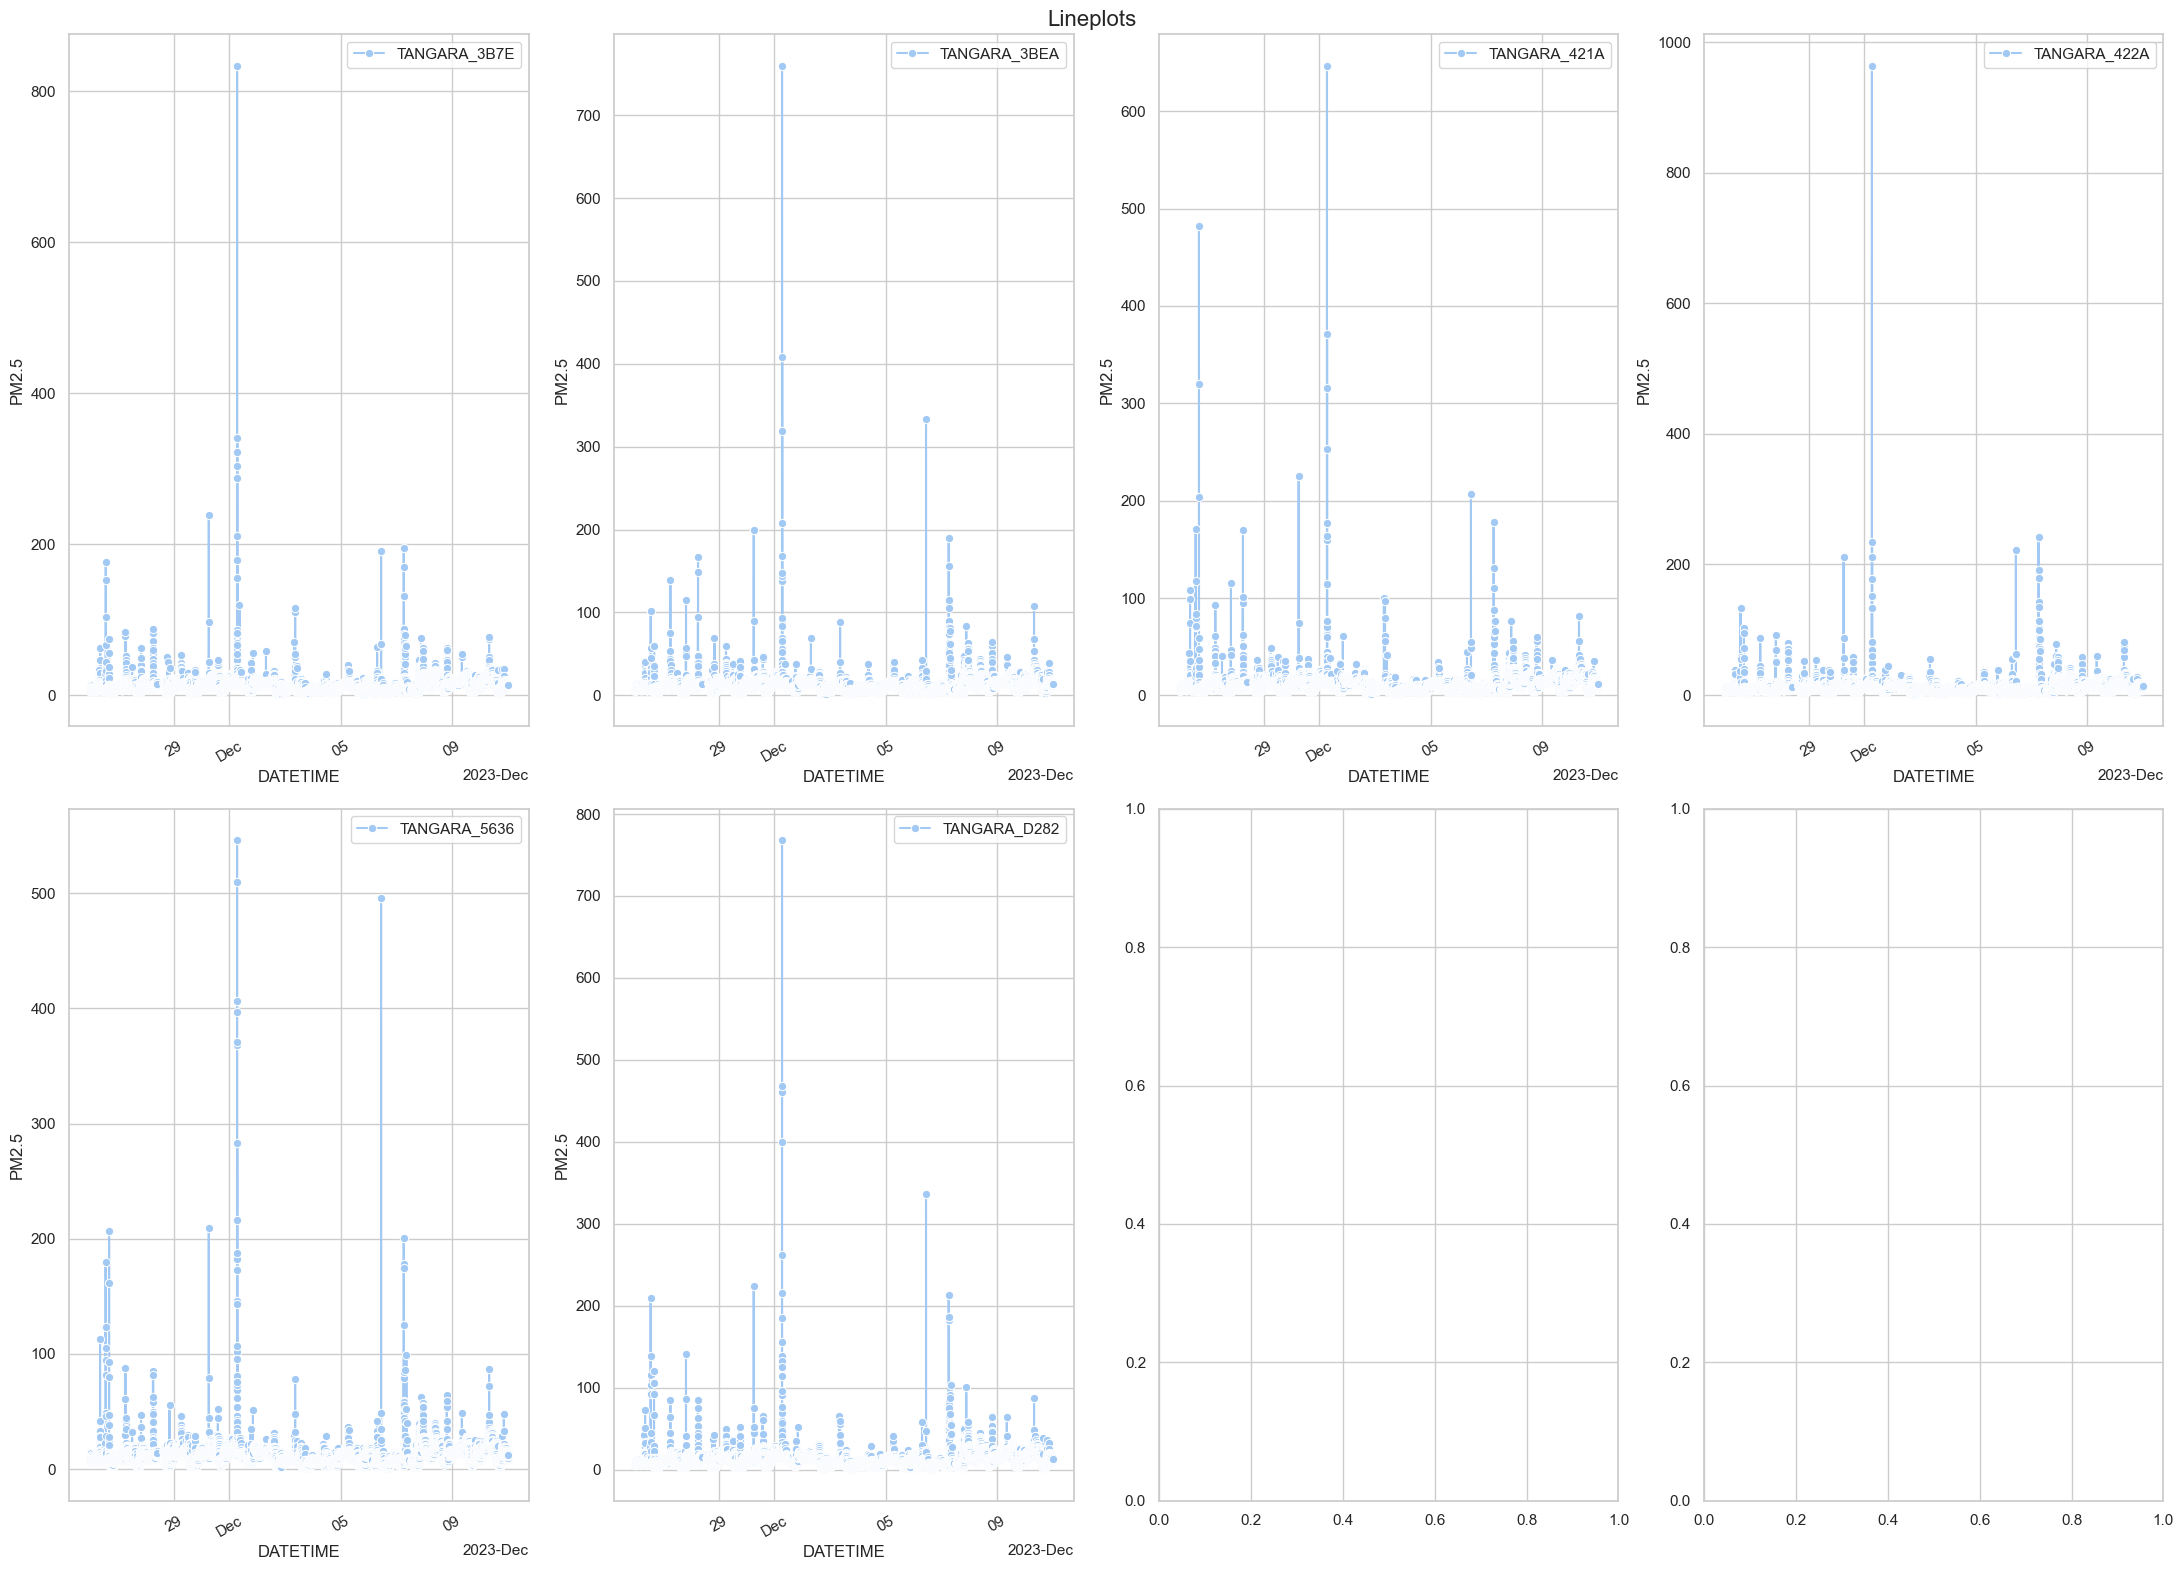

In [8]:
# Plot Lineplots
plot_lines(df_pm25_raw)

## Drop PM2.5 Outliers

In [9]:
# Drop PM2.5 Outliers
df_pm25_clean, resume = drop_pm25_outliers(df_pm25_raw)

2023-12-15 15:37:29.610 | DEBUG    | utils:drop_pm25_outliers:651 - Drop PM2.5 Outliers: <class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43200 entries, 2023-11-26 00:00:00-05:00 to 2023-12-10 23:59:30-05:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TANGARA_3B7E  39204 non-null  float64
 1   TANGARA_3BEA  38828 non-null  float64
 2   TANGARA_421A  38713 non-null  float64
 3   TANGARA_422A  38244 non-null  float64
 4   TANGARA_5636  38339 non-null  float64
 5   TANGARA_D282  38697 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB



In [10]:
# Describe Data
df_pm25_raw.describe()

,TANGARA_3B7E,TANGARA_3BEA,TANGARA_421A,TANGARA_422A,TANGARA_5636,TANGARA_D282
count,39204.000000,38828.000000,38713.000000,38244.000000,38339.000000,38697.000000
mean,11.963958,11.386963,10.675974,10.755831,11.286079,12.175492
std,5.843524,5.664923,5.360653,5.355944,5.474602,6.106629
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7.000000,7.000000,6.000000,7.000000,7.000000,7.000000
50%,11.000000,11.000000,10.000000,10.000000,11.000000,12.000000
75%,16.000000,15.000000,14.000000,15.000000,15.000000,16.000000
max,29.000000,29.000000,28.000000,27.000000,27.000000,32.000000


In [11]:
# Describe Data
df_pm25_clean.describe()

,TANGARA_3B7E,TANGARA_3BEA,TANGARA_421A,TANGARA_422A,TANGARA_5636,TANGARA_D282
count,39204.000000,38828.000000,38713.000000,38244.000000,38339.000000,38697.000000
mean,11.963958,11.386963,10.675974,10.755831,11.286079,12.175492
std,5.843524,5.664923,5.360653,5.355944,5.474602,6.106629
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7.000000,7.000000,6.000000,7.000000,7.000000,7.000000
50%,11.000000,11.000000,10.000000,10.000000,11.000000,12.000000
75%,16.000000,15.000000,14.000000,15.000000,15.000000,16.000000
max,29.000000,29.000000,28.000000,27.000000,27.000000,32.000000


## Histograms

2023-12-15 15:37:32.476 | DEBUG    | utils:plot_hist:512 - Plot Histograms: True


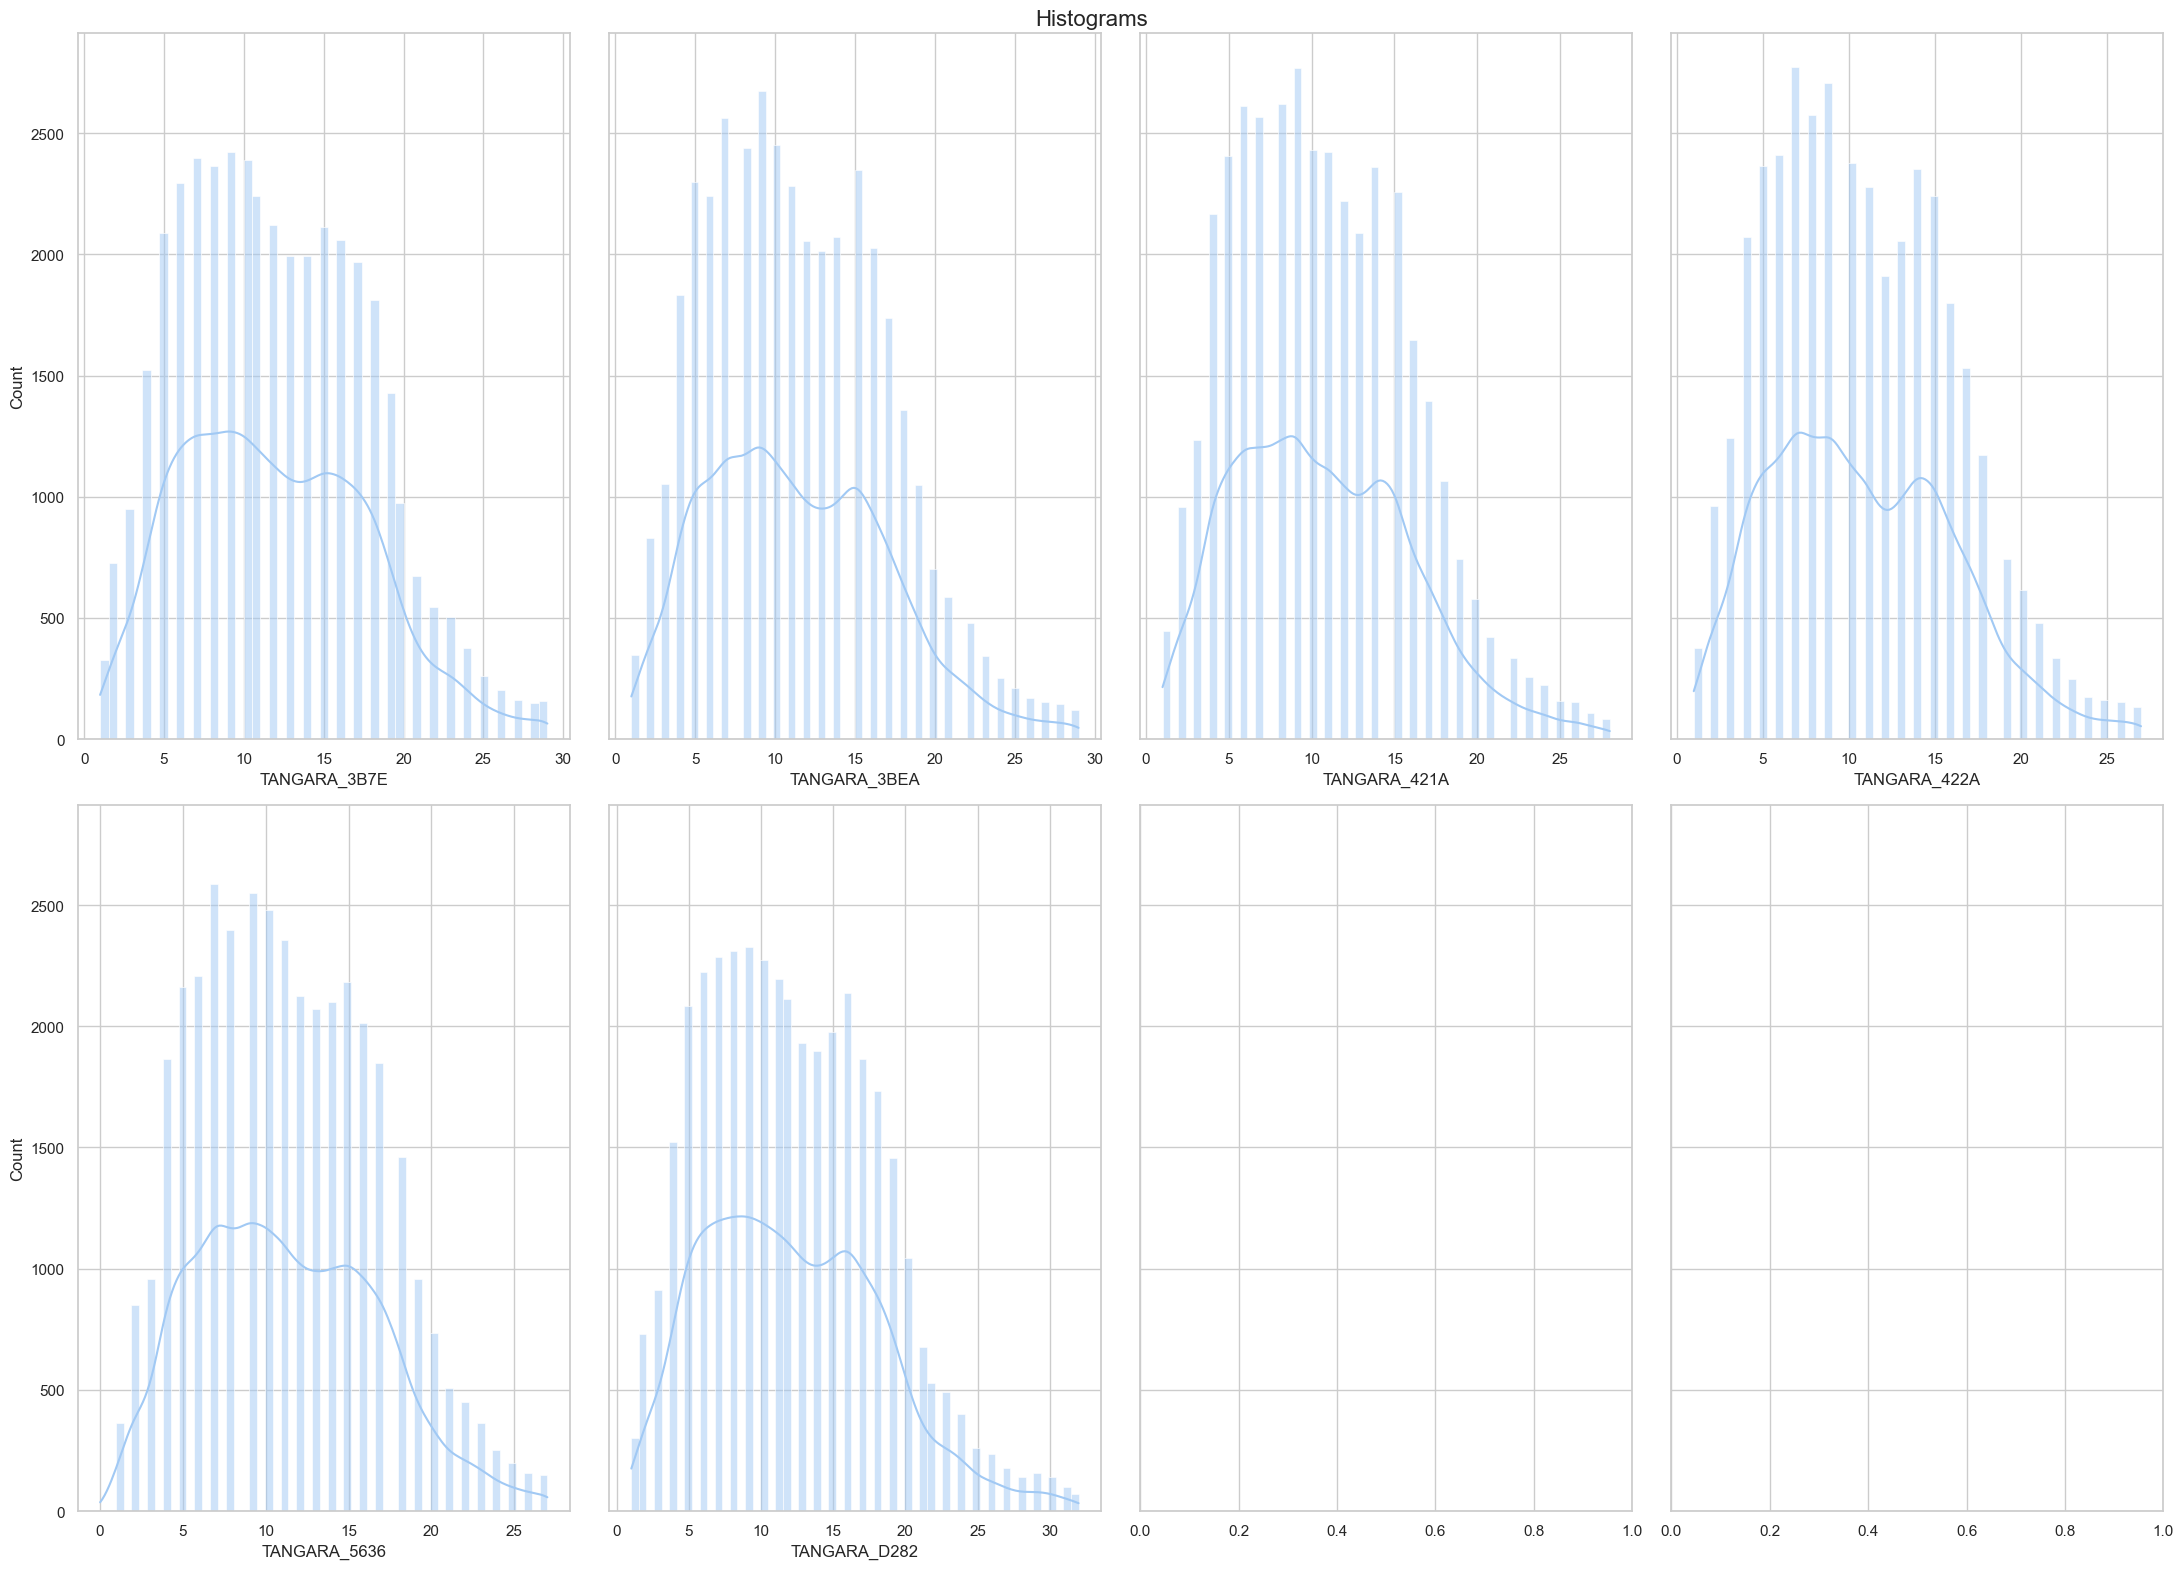

In [12]:
# Plot Histograms
plot_hist(df_pm25_clean)

## Boxplots

2023-12-15 15:37:37.774 | DEBUG    | utils:plot_boxes:545 - Plot Boxplots: True


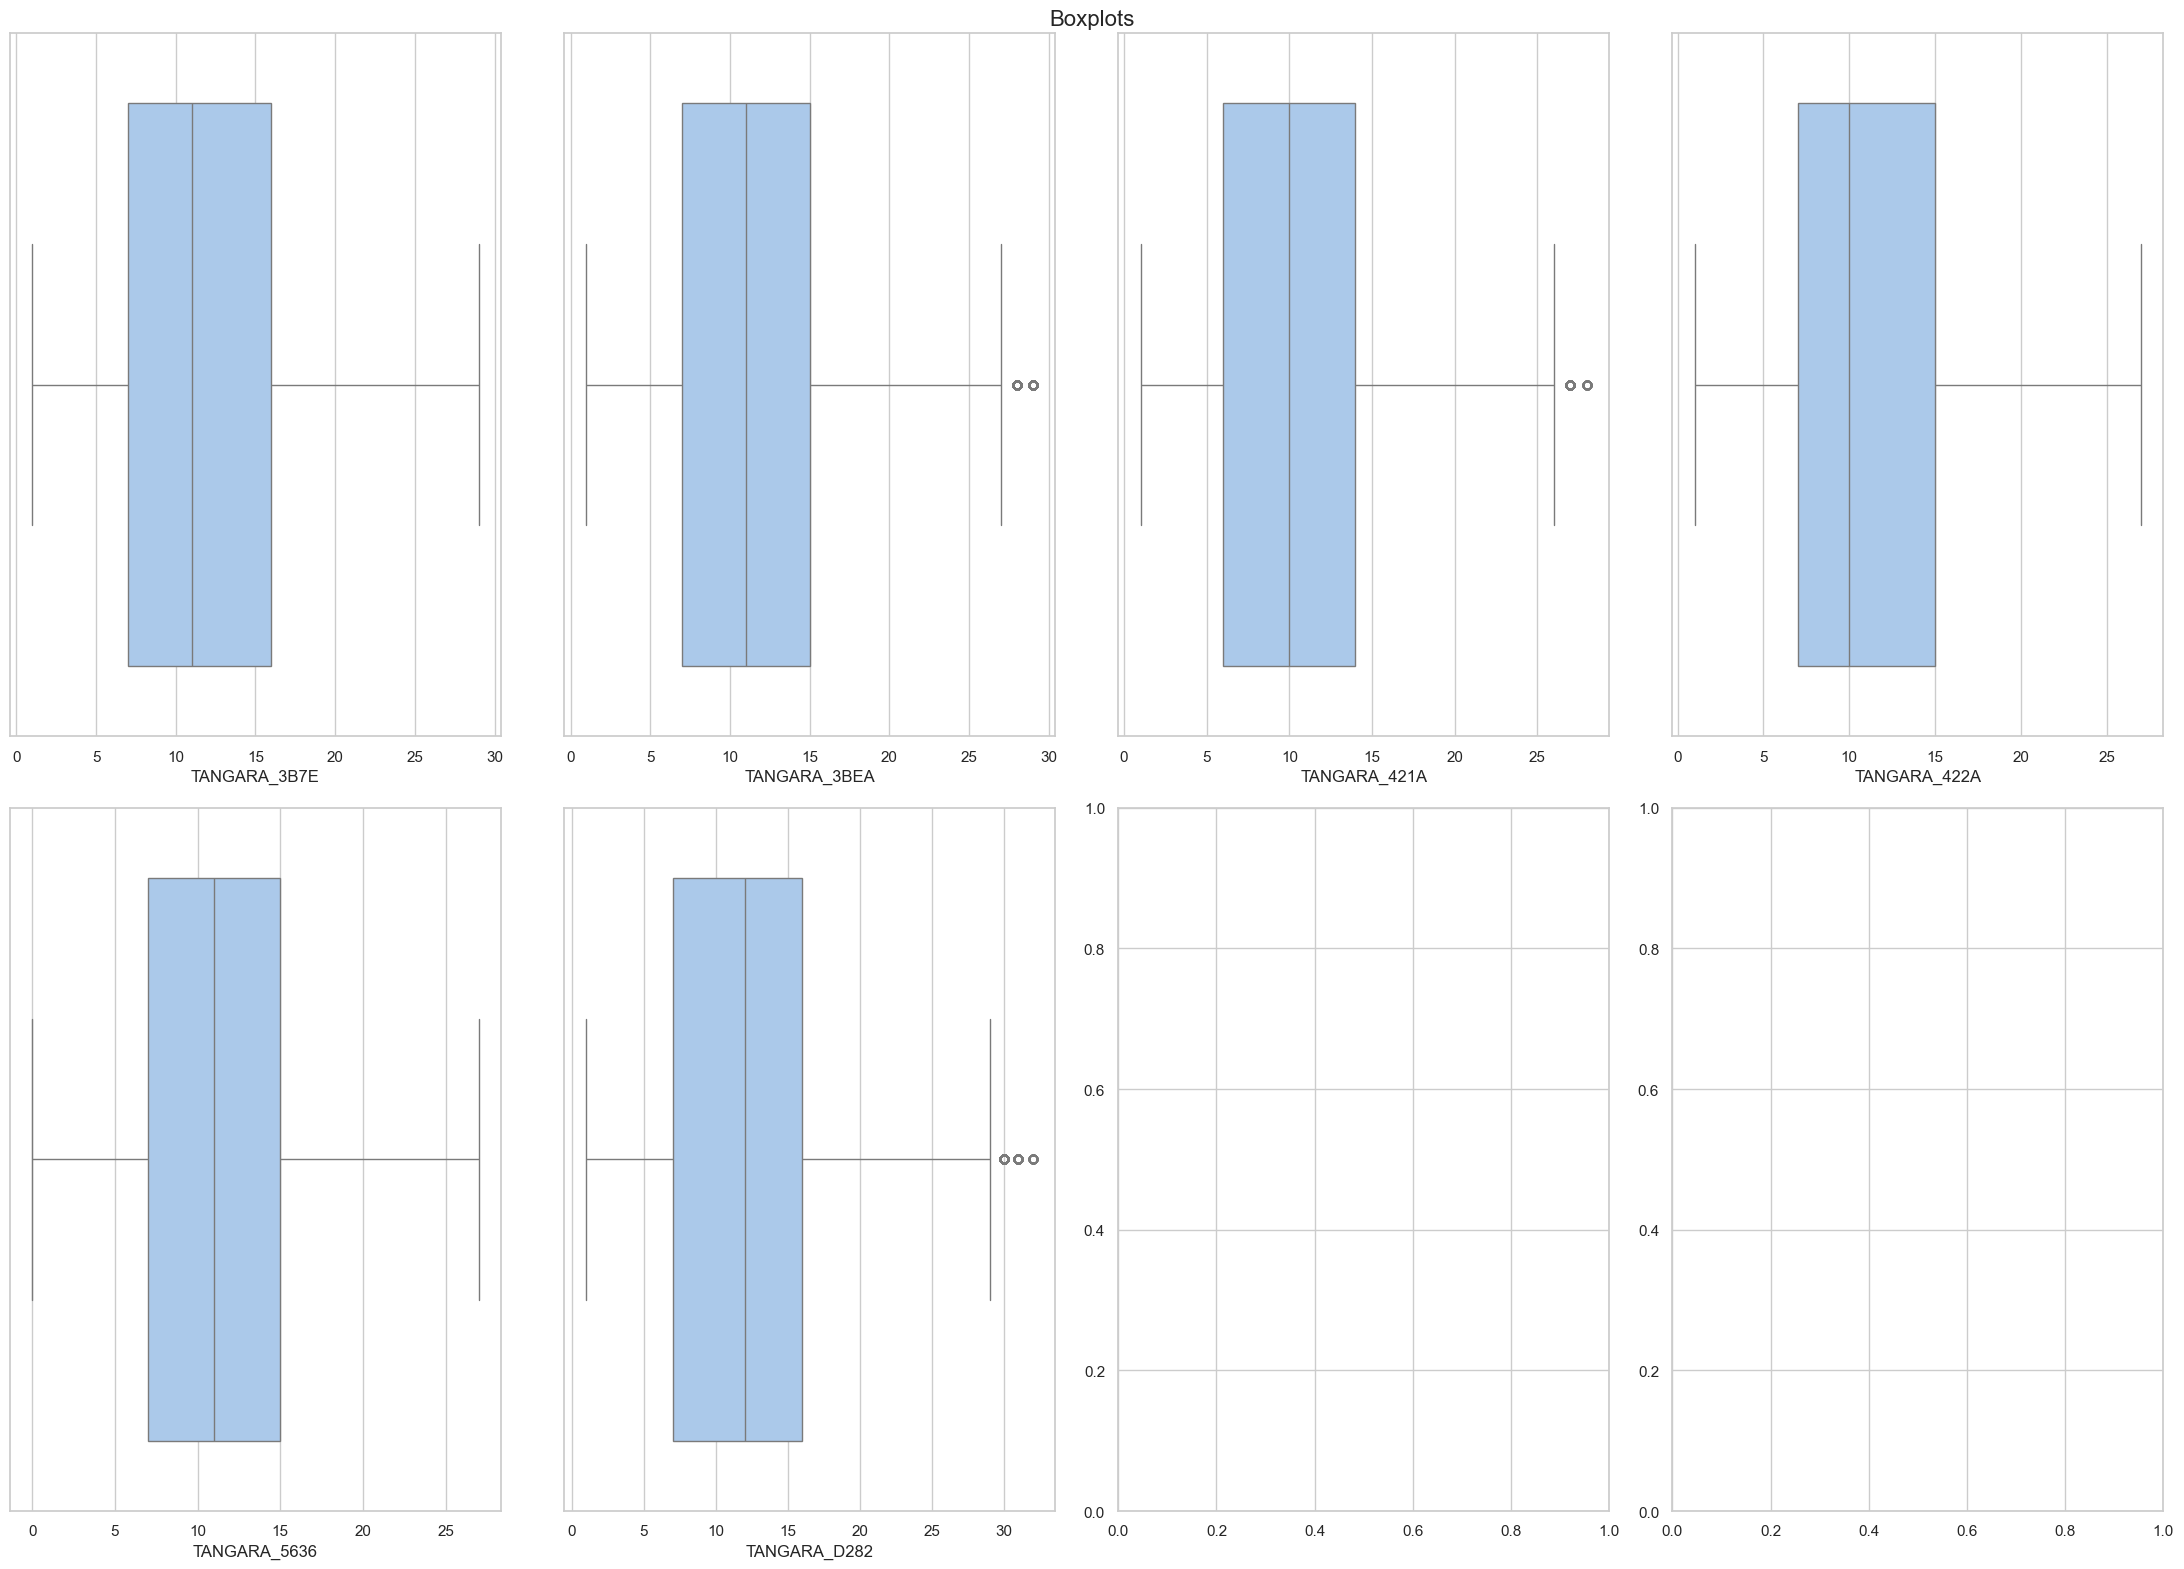

In [13]:
# Plot Boxplots
plot_boxes(df_pm25_clean)

## Lineplots

2023-12-15 15:37:52.634 | DEBUG    | utils:plot_lines:586 - Plot Lineplots: True


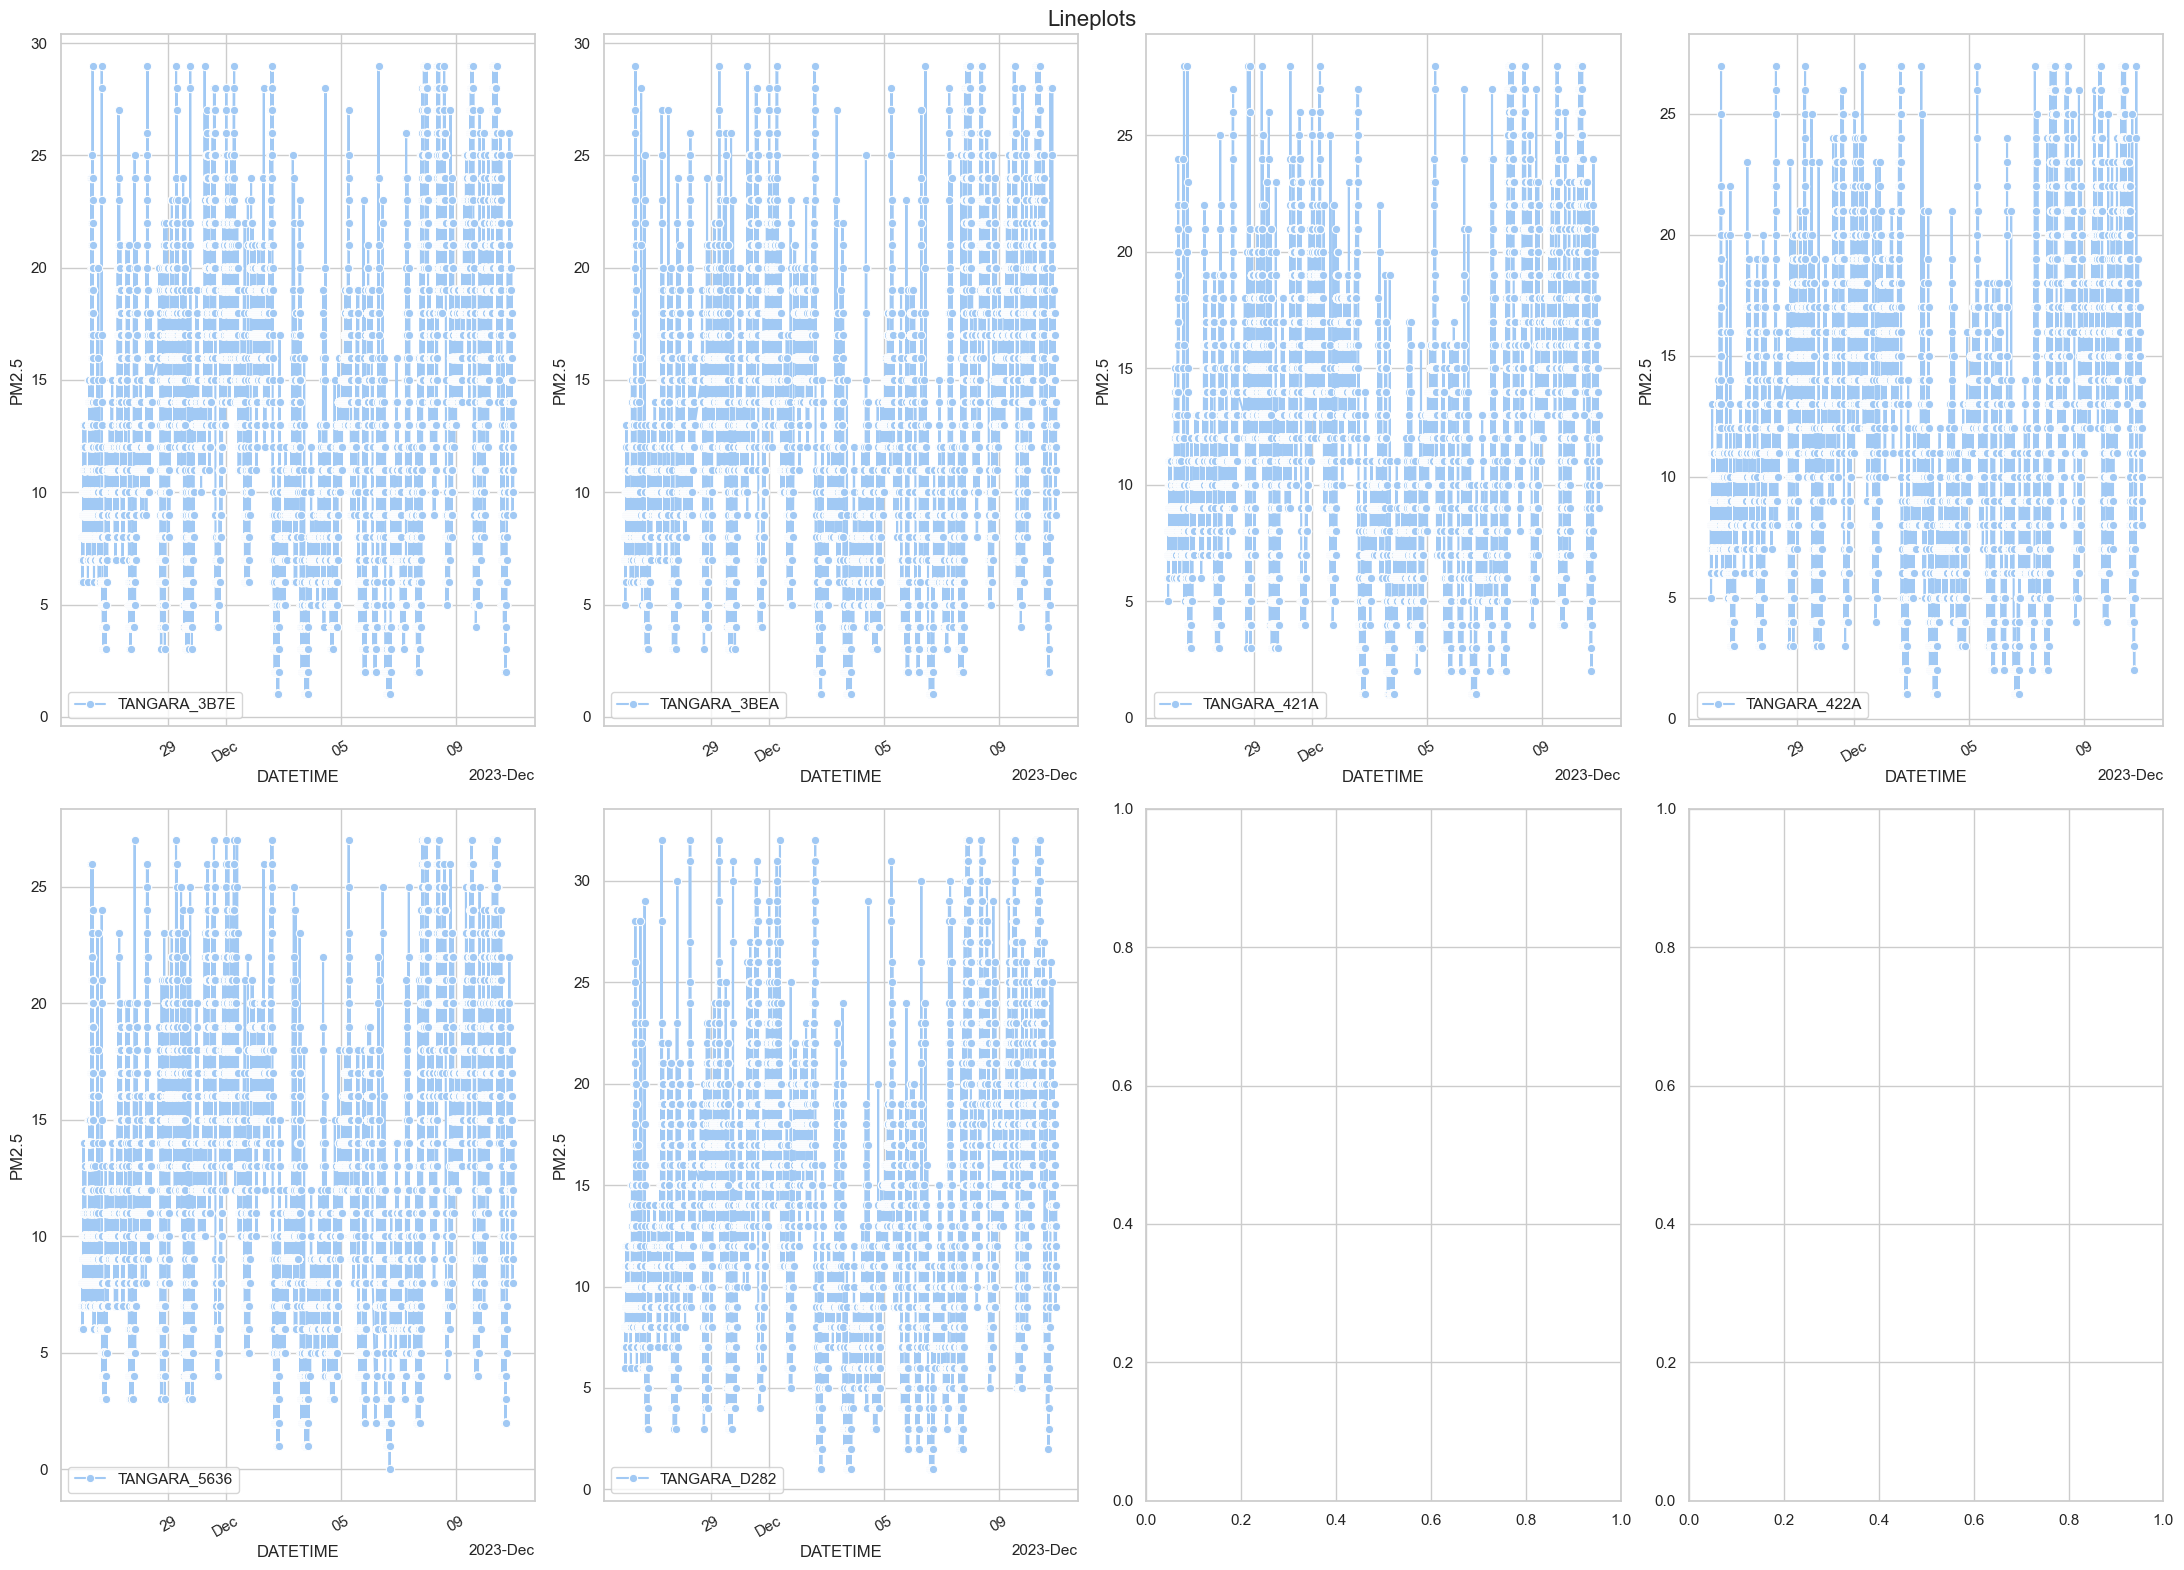

In [14]:
# Plot Lineplots
plot_lines(df_pm25_clean)

In [15]:
# Save PM2.5 Data Frame Sensors into CSV file
df_to_csv(df_pm25_clean, "pm25_clean.csv", datafolder='1_clean')

2023-12-15 15:37:58.762 | DEBUG    | utils:df_to_csv:311 - Save DataFrame: /home/sebaxtian/Workspaces/Tangara/tangara-evaluation/src/data/1_clean/pm25_clean.csv
